<a href="https://colab.research.google.com/github/mschrader15/homework/blob/main/spring-2022/ece-693/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

In machine learning, binary linear classifiers can be utilized for multi-class classificiation in several ways. Two notable approaches include one-against-all and one-against-one. The goal of this homework is to implement multi-class classification using Rosenblatt's perceptrons (or like, see specifics below) using numpy and Tensorflow. 

**One-against-all**

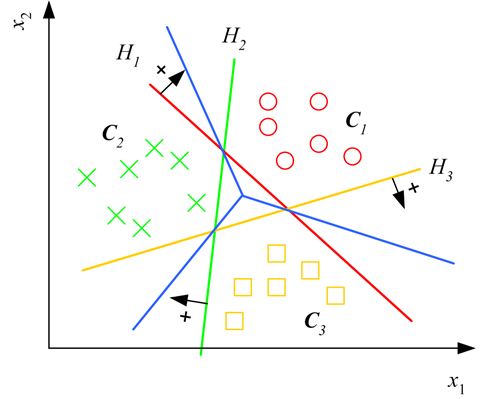

For K classes, this method requires K decision boundaries. Each boundary separates instances of class Ci from the rest of the data. A datapoint x is assigned to class Ci if the classification function $g_i(x)={max_{j=1}}^{K}(g_j(x))$ 


**One-against-one**

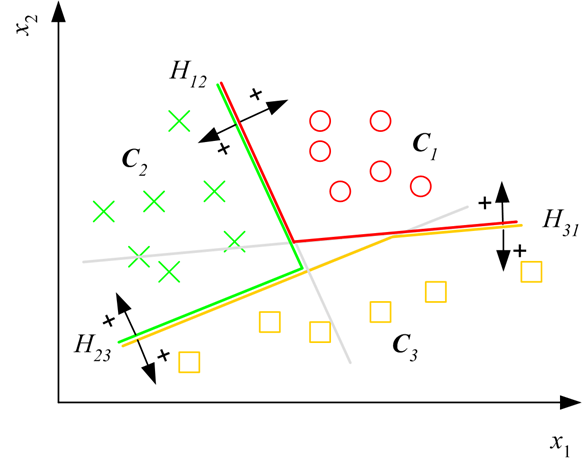

For K classes, this method requires K(K-1)/2 discriminants. Each boundary separates instances of class $C_i$ from class $C_j$, such that:

$g_{ij}(x) =
\begin{cases}
>0,\  if \ x\in C_i\\
≤0,\ if\ x\in C_j\\
\text{don't care otherwise}
\end{cases} $

A datapoint x is assigned to class $C_i$ if $∀ j != i, g_{ij}(x)>0$

**Dataset**

The code below generates the dataset to be used in this homework

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: covariance is not positive-semidefinite.


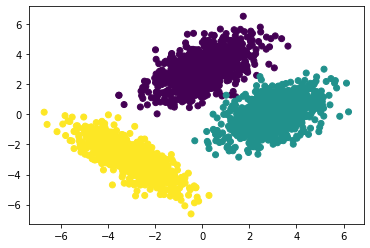

In [ ]:
import numpy as np

num_samples_per_class = 1000
class1_samples = np.random.multivariate_normal(
mean=[0, 3],
cov=[[1, 0.5],[0.5, 1]],
size=num_samples_per_class)

class2_samples = np.random.multivariate_normal(
mean=[3, 0],
cov=[[1, 0.5],[0.5, 1]],
size=num_samples_per_class)

class3_samples = np.random.multivariate_normal(
mean=[-3, -3],
cov=[[-0.75, 1],[1,-0.75]],
size=num_samples_per_class)

#features
features = np.vstack((class1_samples, class2_samples, class3_samples)).astype(np.float32)

#labels
labels = np.vstack((np.ones((num_samples_per_class, 1), dtype="float32"), 
                    2*np.ones((num_samples_per_class, 1), dtype="float32"), 
                    3*np.ones((num_samples_per_class, 1), dtype="float32")))

import matplotlib.pyplot as plt
plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])
plt.show()


**Task 1**

Using the [numpy library](https://numpy.org/numpy-tutorials/), implement predict and train functions for Rosenblatt's perceptron with the hard limiter actication function as defined in the lecture. 

The predict function should take a feature matrix, a matrix of weights and return a vector of predicted variables.

The train function should take a feature matrix, a vector of labels and return a vector of weights of the trained model.

Verify that the training is working by training on a binary dataset of your own choosing and providing [measures of accuracy](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234). For example, you could use any of the two classes from the HW dataset. These should be separable with almost 100% accuracy.

In [ ]:
#your solution goes here

**Task 2**

Using the perceptron functions defined above, implement predict/train functions for multi-class classifier.

The predict function should take a matrix of features, a matrix with weights of the perceptron classifiers and return a vector of labels. Use either one-against-all or one-against-one method when implemeting this function. Justify your method selection in the report.

The train function should take a matrix of features, a vector of labels and return the trained classification model (a matrix with perceptron weights). Here you need to utilize the perceptron train functions developed in Task 1.

Characterize the accuracy of the classifier using the [confusion matrix](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234).



In [ ]:
#your solution goes here

**Task 3**

Implement the same multi-class classfier using [Tensorflow's GradientTape](https://www.tensorflow.org/guide/autodiff) in the training functions (also see examples in Chapter 3 of the textbook).

Notes:
- a hard limiter function is not the best choice here. Use sigmoid or other activation function.
- Keep the functions implemented in the Task 2 the same and redefine the train/predict functions implemened in Task 1
- You could implement a different approach and train all neurons at once



In [ ]:
#your solution goes here

**Grading**

- (10 pts) Report quality / submission requirement followed (see class policy)
- (30 pts) Task 1
- (30 pts) Task 2
- (30 pts) Task 3

**Report** (your report goes here, keep the length manageable)
Report may also be submitted as a pdf document in the same compressed folder.

- Introduction
- Methods
- Results
- Discussion/Conclusions

**Submission**

Using Blackboard, submit the .ipynb file in a compressed folder as defined by the class policy.